In [1]:
import os
import torch
import torch.nn
import torch.optim
import numpy as np
from read_maze import load_maze, get_local_maze_information
import sys
import matplotlib.pyplot as plt
import datetime

In [2]:
'''
代码的来源
https://github.com/alvaroprat97/RL-Maze-Solver/blob/master/Complex_Maze/agent.py
https://github.com/luispsantos/EL2805-Reinforcement-Learning/blob/main/lab2/lab2_instructions.pdf
https://zhuanlan.zhihu.com/p/346165057
https://github.com/xiaoyw71/Reinforcement-learning-practice
https://github.com/luispsantos/EL2805-Reinforcement-Learning/blob/4117514ae3cb3003df3785db64a9dc1d3a2b6954/lab1/problem1/maze.py
https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/CombinedExperienceReplay/memory_solution.py
https://github.com/lukun199/DQN_maze/blob/main/Main.py
'''
GREEN = "#7CFC00"
BLACK = "#000000"
WHITE = "#FFFFFF"
class Qmaze:
    def __init__(self):
        # Reset the total number of steps which the agent has taken
        self.num_steps_taken = 0
        self.rat = (1,1)
        self.goal = (199,199)
        self.rat_path = [self.rat]
        self.around_info = []
        self.state = self.get_state
        self.observation = self.observe_environment

        
    @property
    def reset(self):
        #reset environment
        self.num_steps_taken = 0
        self.rat = (1,1)
        self.goal = (199,199)
        self.rat_path = [self.rat]
        self.around_info = []
        self.state = self.get_state
        self.observation = self.observe_environment

    #get state
    @property
    def get_loc_info(self):
        return self.observation
    
    #get agent position
    @property
    def get_rat_pos(self):
        return self.rat

    #get agent path
    @property
    def get_rat_path(self):
        return self.rat_path
    
    #get surrounding infomation
    @property
    def get_around_info(self):
        col, rol = self.get_rat_pos
        location = get_local_maze_information(rol,col)
        self.around_info = location.copy()
        return self.around_info

    # state(environment surrounding agent)
    @property
    def observe_environment(self):
        col, rol = self.get_rat_pos
        location = get_local_maze_information(rol,col)
        temp = []

        # get local infomation
        for i in range(location.shape[0]):
            for j in range(location.shape[1]):
                if location[i][j][0] == 0:
                    temp.append(0) #wall
                elif location[i][j][0] == 1 and location[i][j][1] ==0:
                    temp.append(1) #no fire and empty
                elif location[i][j][1] >0:
                    temp.append(location[i][j][1]) #fire
        # add position to path
        self.observation = temp
        return self.observation
    
    #state(get state of agent, including: observation and path agent has visited)
    @property
    def get_state(self):
        col, rol = self.get_rat_pos
        location = get_local_maze_information(rol,col)
        temp = []

        # states include observation 9
        for i in range(3):
            for j in range(3):
                temp.append((rol-1+i,col-1+j))

        #add latest 11 moves into states
        if len(self.rat_path) <=400:
            for i in range(400):
                temp.append((199,199))
        else:
            for j in range(1,401):
                temp.append(self.rat_path[-j])
        
        self.state = temp
        return self.state


    def step(self, action, score):
        # action
        action_dir = {"0": {"id":'stay',"step":(0,0)},
                      "1": {"id":'up',"step":(0,-1)},
                      "2": {"id":'left',"step":(-1,0)},
                      "3": {"id":"down","step":(0,1)},
                      "4": {"id":'right',"step":(1,0)}}
        # reward
        rewards_dir = {"move_forward": 0.7,
                       "move_backward":-0.2,
                       "re-visited":-0.5,
                       "blocked":-0.8,
                       "fire":-1.0,
                       "wall":-0.9,
                       "stay":-0.3,
                       "success":100.0,
                      }

        # increment time
        self.num_steps_taken += 1 
        #get action
        act_key = str(action)
        # relative move
        x_relative, y_relative = action_dir[act_key]['step'] 
        x, y = self.rat
        x_expected, y_expected = (1 + x_relative, 1 + y_relative)
        
        # get local info
        local_matrix = self.get_around_info 
        # check first before move
        if local_matrix[y_expected][x_expected][0] == 0: # wall
            return self.get_state, rewards_dir['wall'], False
        if local_matrix[y_expected][x_expected][1] > 0: # fire
            return self.get_state, rewards_dir['fire'], True
        
        # whether block
        observation = self.observe_environment
        is_blocked = False
        if observation[1] !=1 and  observation[3] != 1 and observation[5] != 1 and observation[7] != 1:
            is_blocked == True
        
        # blocked, need to wait the fire to dispear
        if action_dir[act_key]['id'] == 'stay' and is_blocked:
            return self.get_state, rewards_dir['blocked'], False
        elif action_dir[act_key]['id'] == 'stay':
            # lazy rat and give punishment
            return self.get_state, rewards_dir['stay'], False
        

        # sucessfully move
        self.rat = (x+x_relative, y+y_relative)
        # add to path
        self.rat_path.append(self.rat)
        
        #output file
        with open('output/output.txt','a') as f:
            time1 = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            path=self.rat_path
            action = action_dir[act_key]['id']
            surr_info = np.array(observation)
            info = surr_info.reshape((3,3))
            string = '{} {} {}{}{} {} {}{}{}{}{}{}{}{}'.format("Time:",time1,"\n","Local information:","\n",str(info),"\n","Action taken:",action,"\n","Agent move:",str(path[-2]),"--->",str(path[-1]))
            f.write(string)
            f.write('\n')
            f.write('\n')
            
        # sucessful?
        if self.rat == self.goal:
            return self.get_state, rewards_dir['success'], True
        
        # re-visited punishment
        if self.rat in self.rat_path:
            return self.get_state, rewards_dir['re-visited'], False

        # move forward
        if x_inc > 0 and y_inc > 0:
            return self.get_state, rewards_dir['move_forward'], False
        else:
            # move backward
            return self.get_state, rewards_dir['move_backward'], False
    
    def draw_maze(self):
        maze = load_maze()
        rat_path = self.rat_path

        for i in rat_path:
            maze[i[1],i[0]] = 2
        
        # Map a color to each cell in the maze
        col_map = {0: BLACK, 1: WHITE, 2: GREEN}

        # Give a color to each cell
        rows,cols    = maze.shape
        colored_maze = [[col_map[maze[i,j]] for i in range(rows)] for j in range(cols)]

        # Create figure of the size of the maze
        fig = plt.figure(1, figsize=(cols,rows))

        # Remove the axis ticks and add title title
        ax = plt.gca()
        ax.set_title('The Maze')
        ax.set_xticks([])
        ax.set_yticks([])

        # Give a color to each cell
        rows,cols    = maze.shape
        colored_maze = [[col_map[maze[i,j]] for i in range(rows)] for j in range(cols)]

        # Create figure of the size of the maze
        fig = plt.figure(1, figsize=(cols,rows))

        # Create a table to color
        grid = plt.table(cellText=None,
                            cellColours=colored_maze,
                            cellLoc='center',
                            loc=(0,0),
                            edges='closed')
        # Modify the hight and width of the cells in the table
        tc = grid.properties()['children']
        for cell in tc:
            cell.set_height(1.0/rows)
            cell.set_width(1.0/cols)
        
        plt.savefig('output/maze.png',bbox_inches = 'tight')
        

In [3]:
class ExperienceReplayBuffer():
    def __init__(self, input_shape, max_size, batch_size):
        #initial buffer
        self.batch_size = batch_size
        self.mem_size = max_size 
        self.mem_cntr = 0 
        # initialise state memory,new state memory,action memory and reward_memory
        self.state_memory = np.zeros((self.mem_size,*input_shape, 2), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size,*input_shape, 2), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_buffer(self, state, state_, reward, action):
        # memory position
        index = self.mem_cntr % self.mem_size
        # assign memory
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        # increment
        self.mem_cntr += 1

    def sample_buffer(self):
        #sample buffer
        max_mem = min(self.mem_size, self.mem_cntr)
        btch = np.random.choice(max_mem, self.batch_size, replace=False)
        states = self.state_memory[btch]
        states_ = self.new_state_memory[btch]
        actions = self.action_memory[btch]
        rewards = self.reward_memory[btch]
        return states, actions, rewards, states_

    def is_sufficient(self):
        return self.mem_cntr > self.batch_size

In [4]:
class Network(torch.nn.Module):
    #The class initialisation function. 
    #This takes as arguments the dimension of the network's input(the dimension of the state), and the dimension of the network's output (the dimension of the action).
    def __init__(self, input_dims, n_actions, lr):
        # Call the initialisation function of the parent class.
        super(Network, self).__init__()
        # Define the network layers. This example network has two hidden layers, each with 100 units.
        self.layer_1 = torch.nn.Linear(input_dims, 100)
        self.layer_2 = torch.nn.Linear(100, 100)
        self.output_layer = torch.nn.Linear(100,n_actions)
        # optimization function, Loss function and device setting
        self.optimiser = torch.optim.SGD(self.parameters(), lr=lr)
        self.loss = torch.nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    # Function which sends some input data through the network and returns the network's output.
    def forward(self, input):
        layer_1_output = torch.nn.functional.relu(self.layer_1(input))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        action = self.output_layer(layer_2_output)
        return action


In [5]:
class Agent():
    # Function to initialise the agent
    def __init__(self, gamma, epsilon, lr, actions,input_dims, batch_size, mem_size, buffer_size,  episode_min=0.01, episode_dec=5e-7, steps_update=30):
        # Hyperparameter Settings
        self.learn_step_counter  = 0
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.num_actions = actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.episode_min = episode_min
        self.episode_dec = episode_dec
        self.steps_update = steps_update # Steps used to updates Q-network
        self.action_space = [i for i in range(self.num_actions)]
        self.buffer_size = buffer_size
        self.memory = ExperienceReplayBuffer(buffer_size, mem_size, batch_size)
        self.q_network = Network(self.input_dims, self.num_actions, self.lr)
        self.target_q_network = Network(self.input_dims, self.num_actions, self.lr)

    # Take an epsilon-greedy action (uses epsilon_pick equation) and prefered action is found from DQN
    def greedy_epsilon(self, observation):
        # FIND ARGMAX A from predicted Q(S,A)
        if np.random.random() > self.epsilon:
            prediction = self.q_network.forward(torch.tensor([observation], dtype=torch.float).to(self.q_network.device))
            action = torch.argmax(prediction).item()
        # otherwise choose random action
        else:
            action = np.random.choice(self.action_space)
        return action

    # store all the elements
    def store_transition(self, state, state_, reward, action):
        self.memory.store_buffer(state, state_, reward, action)

    # Update target network as a copy of the Q network.
    def update_target_q_network(self):
        if self.learn_step_counter % self.steps_update == 0:
            dqn_dict =  torch.nn.Module.state_dict(self.q_network)
            torch.nn.Module.load_state_dict(self.target_q_network,dqn_dict)
      
    # Function to decrease our epsilon depending if we are exploring or if epsilon is above its threshold
    def dec_epsilon(self):
        if self.epsilon > self.episode_min:
            self.epsilon = self.epsilon - self.episode_dec
        else:
            self.episode_min

    def learn(self):
        # fill the memory
        if not self.memory.is_sufficient():
            return

        # Set all the gradients stored in the optimiser to zero.
        self.q_network.optimiser.zero_grad()
        self.update_target_q_network()

        # set memory
        state, actions, reward, state_ = self.memory.sample_buffer()
        index = np.arange(self.batch_size)
        state = torch.tensor(state).to(self.q_network.device)
        action = torch.tensor(actions).to(self.q_network.device)
        rewards = torch.tensor(reward).to(self.q_network.device)
        state_ = torch.tensor(state_).to(self.q_network.device)
        
        
        # predict the Q Values of all actions
        network_prediction  = self.q_network.forward(state)[index,action]
        predicted_Q = torch.max(network_prediction,dim=1)[0]
        # successor state prediction from target network
        target_network_prediction = self.target_q_network.forward(state_)[index,action]
        # Q value predicted by network for successor state
        bellman_temp = torch.max(target_network_prediction,dim=1)[0]

        # R + gamma*Q
        q_target = rewards + self.gamma * torch.unsqueeze(bellman_temp,1)
        
        # Calculate the loss for this transition.
        loss = self.q_network.loss(q_target, predicted_Q)
        # Compute the gradients based on this loss,the gradients of the loss with respect to the Q-network parameters.
        loss.backward()
        # Take one gradient step to update the Q-network.
        self.q_network.optimiser.step()
        # Iterate the training counter
        self.learn_step_counter += 1
        # epsilon decrease
        self.dec_epsilon()

...starting...
-----------------The 0 trial-------------------
-----------------The 1 trial-------------------
-----------------The 2 trial-------------------
-----------------The 3 trial-------------------
-----------------The 4 trial-------------------
Plotting


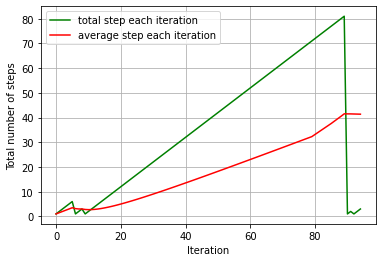

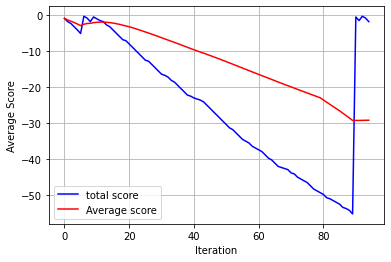

draw maze


In [6]:
if __name__ == '__main__':
    # Default Parameters
    # initial maze
    env = Qmaze()
    gamma = 0.90
    epsilon = 5
    lr = 0.00005
    epsilon_min = 0.05
    epsilon_dec = 1e-6
    input_dims = 2
    actions = 5
    replace_testnet = 30
    memsize = 1000000
    batch_size = 128
    buffer_size = [409]
    display_on =True
    score_list = []
    scores_avg = []
    step_list = []
    step_avg = []
    # initial agent
    agent = Agent(
        gamma=gamma, epsilon=epsilon, lr=lr,
        input_dims=input_dims,buffer_size= buffer_size, actions=actions, mem_size=memsize, 
        episode_min=epsilon_min,batch_size=batch_size, episode_dec=epsilon_dec, steps_update=replace_testnet)
    
    # This determines whether the environment will be displayed on each each step.
    maze = load_maze()
    print('...starting...')
    # initial observation
    env.reset
    
    for i in range(epsilon):
        # one trial learning signal
        done = False
        #get state(the observation surrounding)
        observation = env.get_state

        steps = 0
        #intitial score
        score = 0
        # one trial learning
        while not done:
            
            # Get the state and action from the agent
            observation = env.get_state
            action = agent.greedy_epsilon(observation)
            # Get the next state(observation) and the reward and done
            observation_, reward, done = env.step(action, score)
            # add reward
            score += reward
            steps +=1
            # storage info
            step_list.append(steps)
            step_avg.append(np.mean(step_list[-80:]))
            score_list.append(score)
            scores_avg.append(np.mean(score_list[-80:]))
            # store memory
            agent.store_transition(observation, observation_, reward, action)
            # agent learning
            agent.learn()
            # swap observation
            observation = observation_

        # whether success
        if env.rat==env.goal:
            print("sucessful")
            break
        else:
            print("-----------------The",i,"trial-------------------")
    
    print('Plotting')
    plt.plot(step_list,color = "g",label='total step each iteration')
    plt.plot(step_avg,color = "r", label='average step each iteration')
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('Total number of steps')
    plt.legend()
    plt.savefig('output/Score.png',bbox_inches = 'tight')
    plt.show()
    
    plt.plot(score_list,color = "b",label = 'total score')
    plt.plot(scores_avg,color = "r", label='Average score')
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.ylabel('Average Score')
    plt.legend()
    plt.savefig('output/average_score.png',bbox_inches = 'tight')
    plt.show()
    if display_on:
        print("draw maze")
        env.draw_maze()
